## Keras Bag-of-Words Sequential Model

Up to this point the data has already been preprocessed. The purpose of this notebook is to find the best neural network model using grid-search parameter tuning techniques.

### Data Prep
First we need to load the data which has been stored in a compressed format.

In [2]:
import pandas as pd
import os

# Change the working directory
os.chdir('/home/ec2-user/Notebooks/seis735_aws/')

# Read the training data
df_train = pd.read_csv('data/train_freq.gz', compression='gzip', encoding='ISO-8859-1')
df_test = pd.read_csv('data/test_freq.gz', compression='gzip', encoding='ISO-8859-1')

print(df_train.shape)
print(df_test.shape)

(2988, 23903)
(333, 23903)


There are nine different classes in our target attribute. These classes need to be converted into dummy variables in order to be used in a neural network prediction. 

In [3]:
y_train = pd.get_dummies(df_train[['Class']], prefix='y', columns=['Class'])
y_test = pd.get_dummies(df_test[['Class']], prefix='y', columns=['Class'])

print(y_train.shape)
print(y_test.shape)

(2988, 9)
(333, 9)


Now we need to format the data so it may be ingested by a neural network. This means dropping a few of the meaningless columns, as well as converting the dataframe to a matrix format.

In [4]:
# Keep only the predictors
df_train.drop(['ID','Gene','Variation'], inplace=True, axis=1)
df_test.drop(['ID','Gene','Variation'], inplace=True, axis=1)

# Convert predictors to matrix format
x_train = df_train.as_matrix()[:,1:]
y_train_true = df_train.as_matrix()[:,0]
y_train = y_train.as_matrix()


x_test = df_test.as_matrix()[:,1:]
y_test_true = df_test.as_matrix()[:,0]
y_test = y_test.as_matrix()

del df_train, df_test

### Tuning Hidden Layers

The data is now ready to be fed into a Keras neural network model. We want to train the network in a step-wise fashion using a grid-search technique. Let's define a class to help us with the grid-search. There is a pre-defined sklearn GridSearchCV class which I could have used for this task. However, the customer class below will be much faster as it allows for early stopping.

In [18]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from keras.models import load_model

class KerasClassifierGridSearchCV(object):
    """
    Use cross-fold validation to perform parameter tuning on a Keras feed forward neural network.  
    
    """
    def __init__(self, params, nfolds, seed):
        self.params = params
        self.nfolds = nfolds
        self.seed = seed
        self.models = {}
        self.results = {}
        self.avg_results = {}
    # Return the trained models    
    def get_models(self):
        return (self.models)
    # Return the results for each of the trained models
    def get_results(self):
        return (self.results)
    # Return the overall avg results for each parameter
    def get_avg_results(self):
        return (self.avg_results)
    # Fit 1 model per n-fold per parameter    
    def fit(self, build_fn, X_train, Y_train, epochs=50, batch_size=50, early_stopping_rounds=5, min_delta=0.001):
        # Split the dataset into k-folds
        kf = KFold(n_splits=self.nfolds, random_state=self.seed, shuffle=True)
        # Iterate over the parameter grid
        for i, p in enumerate(self.params):
            print('Training with: %s' % p)
            # Initializing empty states
            average = []
            weights = []
            #fold_number = 1
            # Iterate over the k-folds
            for train_index, test_index in kf.split(X_train):             
                # Get the training and test data for each fold
                x_train, x_test = X_train[train_index], X_train[test_index]
                y_train, y_test = Y_train[train_index], Y_train[test_index]
                # Create the estimator
                estimator = build_fn(p)
                # To make training faster on subsequent folds, use pre-trained weights from the first fold
                #if fold_number > 1:
                #    estimator.set_weights(w1)
                # Early stopping
                early_stopping = EarlyStopping(monitor='val_acc', min_delta=min_delta, patience=early_stopping_rounds, verbose=True)
                # Train the estimator
                estimator.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
                # Get the mse
                avg = estimator.evaluate(x_test, y_test)
                # Append the mean squared error
                average.append(avg[1])
                # Save the model
                weights.append(estimator)
                # Get the trained weights from the first fold
                #if fold_number == 1:
                #    w1 = estimator.get_weights()
                #fold_number += 1
            # Save the results and model weights    
            self.models[p] = weights
            self.results[p] = average
            self.avg_results[p] = np.mean(average)

Now we need to initialize the parameters and model that we want to train. The first thing we are going to test is the number of neurons to use in the first hidden layer. We will utilize early stopping, which will cause training to cease if there is no improvement in the validation score.

In [19]:
# Create a model with a single hidden layer
def hidden_1(neurons=100):
    model = Sequential()
    model.add(Dense(neurons, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return (model)

# Setting the input params
neurons = [500, 1000, 1500, 2000] # Number of neurons to test in the first hidden layer
folds = 3 # Number of k-folds
seed = 1986 # Random seed for reproducibility

# Training the model
gs1 = KerasClassifierGridSearchCV(neurons, folds, seed)
gs1.fit(hidden_1, x_train, y_train, epochs=50, batch_size=50, early_stopping_rounds=5, min_delta=0.001)

Training with: 500
Train on 1992 samples, validate on 996 samples
Epoch 1/50
 - 4s - loss: 2.0226 - acc: 0.3007 - val_loss: 1.8745 - val_acc: 0.2530
Epoch 2/50
 - 3s - loss: 1.7669 - acc: 0.3128 - val_loss: 1.7752 - val_acc: 0.3544
Epoch 3/50
 - 3s - loss: 1.6696 - acc: 0.3780 - val_loss: 1.6823 - val_acc: 0.4006
Epoch 4/50
 - 3s - loss: 1.5639 - acc: 0.4488 - val_loss: 1.5912 - val_acc: 0.4157
Epoch 5/50
 - 3s - loss: 1.4592 - acc: 0.4849 - val_loss: 1.4991 - val_acc: 0.4649
Epoch 6/50
 - 3s - loss: 1.3622 - acc: 0.5266 - val_loss: 1.4216 - val_acc: 0.5000
Epoch 7/50
 - 3s - loss: 1.2791 - acc: 0.5718 - val_loss: 1.3629 - val_acc: 0.5201
Epoch 8/50
 - 3s - loss: 1.2088 - acc: 0.6024 - val_loss: 1.3192 - val_acc: 0.5321
Epoch 9/50
 - 3s - loss: 1.1458 - acc: 0.6285 - val_loss: 1.2830 - val_acc: 0.5412
Epoch 10/50
 - 3s - loss: 1.0897 - acc: 0.6536 - val_loss: 1.2596 - val_acc: 0.5502
Epoch 11/50
 - 3s - loss: 1.0413 - acc: 0.6667 - val_loss: 1.2494 - val_acc: 0.5452
Epoch 12/50
 - 3s -

Epoch 19/50
 - 6s - loss: 0.6172 - acc: 0.7987 - val_loss: 1.0970 - val_acc: 0.5964
Epoch 20/50
 - 6s - loss: 0.5918 - acc: 0.8037 - val_loss: 1.0982 - val_acc: 0.5964
Epoch 21/50
 - 6s - loss: 0.5679 - acc: 0.8092 - val_loss: 1.0875 - val_acc: 0.6054
Epoch 22/50
 - 6s - loss: 0.5481 - acc: 0.8153 - val_loss: 1.1031 - val_acc: 0.6074
Epoch 23/50
 - 6s - loss: 0.5297 - acc: 0.8223 - val_loss: 1.1050 - val_acc: 0.5994
Epoch 24/50
 - 6s - loss: 0.5133 - acc: 0.8208 - val_loss: 1.0939 - val_acc: 0.5964
Epoch 25/50
 - 6s - loss: 0.4978 - acc: 0.8268 - val_loss: 1.1078 - val_acc: 0.6054
Epoch 26/50
 - 6s - loss: 0.4805 - acc: 0.8278 - val_loss: 1.1231 - val_acc: 0.6044
Epoch 27/50
 - 6s - loss: 0.4659 - acc: 0.8373 - val_loss: 1.1186 - val_acc: 0.6094
Epoch 28/50
 - 6s - loss: 0.4562 - acc: 0.8373 - val_loss: 1.1104 - val_acc: 0.6124
Epoch 29/50
 - 6s - loss: 0.4425 - acc: 0.8384 - val_loss: 1.1104 - val_acc: 0.6004
Epoch 30/50
 - 6s - loss: 0.4309 - acc: 0.8459 - val_loss: 1.1177 - val_acc:

Epoch 2/50
 - 9s - loss: 1.7025 - acc: 0.3589 - val_loss: 1.6124 - val_acc: 0.4508
Epoch 3/50
 - 9s - loss: 1.5273 - acc: 0.4749 - val_loss: 1.4575 - val_acc: 0.5151
Epoch 4/50
 - 9s - loss: 1.3597 - acc: 0.5467 - val_loss: 1.3381 - val_acc: 0.5422
Epoch 5/50
 - 9s - loss: 1.2351 - acc: 0.5914 - val_loss: 1.2575 - val_acc: 0.5542
Epoch 6/50
 - 9s - loss: 1.1350 - acc: 0.6340 - val_loss: 1.1993 - val_acc: 0.5733
Epoch 7/50
 - 9s - loss: 1.0531 - acc: 0.6511 - val_loss: 1.1605 - val_acc: 0.6034
Epoch 8/50
 - 9s - loss: 0.9810 - acc: 0.6742 - val_loss: 1.1368 - val_acc: 0.5984
Epoch 9/50
 - 9s - loss: 0.9176 - acc: 0.6928 - val_loss: 1.1102 - val_acc: 0.6104
Epoch 10/50
 - 9s - loss: 0.8643 - acc: 0.7108 - val_loss: 1.0992 - val_acc: 0.6145
Epoch 11/50
 - 9s - loss: 0.8179 - acc: 0.7249 - val_loss: 1.0861 - val_acc: 0.6135
Epoch 12/50
 - 9s - loss: 0.7674 - acc: 0.7359 - val_loss: 1.0710 - val_acc: 0.6205
Epoch 13/50
 - 9s - loss: 0.7275 - acc: 0.7550 - val_loss: 1.0681 - val_acc: 0.6215


Epoch 14/50
 - 11s - loss: 0.6768 - acc: 0.7646 - val_loss: 0.9892 - val_acc: 0.6235
Epoch 15/50
 - 11s - loss: 0.6409 - acc: 0.7716 - val_loss: 1.0047 - val_acc: 0.6265
Epoch 16/50
 - 12s - loss: 0.6093 - acc: 0.7851 - val_loss: 0.9781 - val_acc: 0.6396
Epoch 17/50
 - 12s - loss: 0.5811 - acc: 0.7952 - val_loss: 0.9968 - val_acc: 0.6305
Epoch 18/50
 - 12s - loss: 0.5530 - acc: 0.8007 - val_loss: 0.9785 - val_acc: 0.6406
Epoch 19/50
 - 12s - loss: 0.5293 - acc: 0.8087 - val_loss: 0.9908 - val_acc: 0.6406
Epoch 20/50
 - 12s - loss: 0.5099 - acc: 0.8148 - val_loss: 1.0036 - val_acc: 0.6396
Epoch 21/50
 - 11s - loss: 0.4889 - acc: 0.8243 - val_loss: 0.9945 - val_acc: 0.6456
Epoch 22/50
 - 11s - loss: 0.4732 - acc: 0.8268 - val_loss: 1.0189 - val_acc: 0.6145
Epoch 23/50
 - 11s - loss: 0.4601 - acc: 0.8303 - val_loss: 1.0151 - val_acc: 0.6345
Epoch 24/50
 - 11s - loss: 0.4468 - acc: 0.8358 - val_loss: 1.0372 - val_acc: 0.6255
Epoch 25/50
 - 11s - loss: 0.4349 - acc: 0.8394 - val_loss: 1.030

The model is ready to be trained. 

Take a look at the overall CV results. The results are displayed as **Accuracy**, so a higher number indicates better results.

In [20]:
gs1.get_avg_results()

{500: 0.6147925033467202,
 1000: 0.61880856760374836,
 1500: 0.6248326639892906,
 2000: 0.61378848728246316}

Since the 1000 neuron architecture is best, let's look at the individual scores from n-fold. The first n-fold performs the best, so let's use that pre-trained model and evaluate it against the entire dataset.

In [21]:
gs1.get_results()

{500: [0.5993975903614458, 0.62048192771084343, 0.62449799196787148],
 1000: [0.61044176706827313, 0.6224899598393574, 0.62349397590361444],
 1500: [0.61044176706827313, 0.62650602409638556, 0.6375502008032129],
 2000: [0.60341365461847385, 0.61345381526104414, 0.62449799196787148]}

We don't want to re-train the model from scratch. So get the best model and weights from the grid search object.

In [22]:
from keras.callbacks import ModelCheckpoint

# Get the best model from the 1000 neuron n-folds
best_model = gs1.get_models()[1500][2]

# Save the best model in case we want to reference it later
best_model.save('models/iteration1.h5')

Train the model on the entire dataset. Use checkpoints to save the best iteration. This is usefull if the best iteration isn't the final epoch, which is likely to be the case.

In [24]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, verbose=True)

# Checkpoint - used to get the best weights during the model training process
checkpoint = ModelCheckpoint(filepath='models/best_weights.h5', monitor='val_acc', save_best_only=True)

# Fit the pre-trained best model on the entire dataset
best_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping, checkpoint], verbose=2)

Train on 2988 samples, validate on 333 samples
Epoch 1/50
 - 40s - loss: 0.5333 - acc: 0.7999 - val_loss: 1.0141 - val_acc: 0.6456
Epoch 2/50
 - 41s - loss: 0.5122 - acc: 0.8025 - val_loss: 1.0263 - val_acc: 0.6517
Epoch 3/50
 - 40s - loss: 0.4918 - acc: 0.8046 - val_loss: 1.0227 - val_acc: 0.6757
Epoch 4/50
 - 20s - loss: 0.4722 - acc: 0.8143 - val_loss: 1.0296 - val_acc: 0.6607
Epoch 5/50
 - 20s - loss: 0.4644 - acc: 0.8149 - val_loss: 1.0132 - val_acc: 0.6757
Epoch 6/50
 - 39s - loss: 0.4486 - acc: 0.8233 - val_loss: 1.0207 - val_acc: 0.6817
Epoch 7/50
 - 20s - loss: 0.4356 - acc: 0.8230 - val_loss: 1.0509 - val_acc: 0.6787
Epoch 8/50
 - 20s - loss: 0.4269 - acc: 0.8246 - val_loss: 1.1046 - val_acc: 0.6727
Epoch 9/50
 - 20s - loss: 0.4155 - acc: 0.8280 - val_loss: 1.0309 - val_acc: 0.6637
Epoch 10/50
 - 20s - loss: 0.4058 - acc: 0.8313 - val_loss: 1.0769 - val_acc: 0.6667
Epoch 11/50
 - 20s - loss: 0.4003 - acc: 0.8290 - val_loss: 1.0970 - val_acc: 0.6787
Epoch 00011: early stopping

Now make the predictions and evaluate the confusion matrix. First we'll define a helper function for plotting a confusion matrix. Then we'll make the predictions and do the plotting.

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


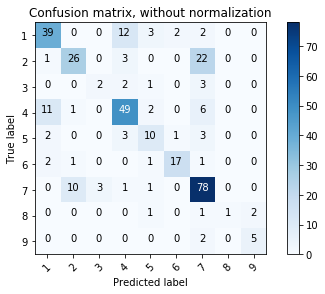

In [26]:
# Load the best iteration
best_model = load_model('models/best_weights.h5')

# Make the predictions
preds = best_model.predict_classes(x_test)
preds = [i + 1 for i in preds]

# Create the confusion matrix
cm = confusion_matrix(y_test_true, preds, labels=[1,2,3,4,5,6,7,8,9])

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[1,2,3,4,5,6,7,8,9], title='Confusion matrix, without normalization')
plt.show()

In [27]:
# Calculate accuracy
acc = np.sum(np.diag(cm)) / np.sum(cm)
print('Accuracy: %0.5f' % acc)
print(best_model.evaluate(x_test, y_test))

Accuracy: 0.68168
333/333 [==============================] - 1s 2ms/step
[1.0207363470896587, 0.68168168221866043]


In [28]:
# Save the model in case we want to reference it later
best_model.save('models/iteration1.h5')

Now let's check if we can get even better performance if we are to add another hidden layer to the architecture. 

In [29]:
# Test the impact of adding a hidden layer
# Use the pre-trained weights from the previous run
def two_layers(neurons=2):
    model = Sequential()
    model.add(Dense(2000, input_dim=x_train.shape[1], activation='relu'))
    if neurons > 0:
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return (model)

# Setting the input params
neurons = [0, 250, 500, 750] # Number of neurons to test in the first hidden layer
folds = 3 # Number of k-folds
seed = 1986 # Random seed for reproducibility

# Training the model
gs2 = KerasClassifierGridSearchCV(neurons, folds, seed)
gs2.fit(two_layers, x_train, y_train, epochs=50, batch_size=50, early_stopping_rounds=5, min_delta=0.001)

Training with: 0
Train on 1992 samples, validate on 996 samples
Epoch 1/50
 - 13s - loss: 1.9026 - acc: 0.3032 - val_loss: 1.8133 - val_acc: 0.2530
Epoch 2/50
 - 11s - loss: 1.6510 - acc: 0.3956 - val_loss: 1.6321 - val_acc: 0.3825
Epoch 3/50
 - 12s - loss: 1.4608 - acc: 0.4739 - val_loss: 1.4565 - val_acc: 0.4910
Epoch 4/50
 - 11s - loss: 1.3022 - acc: 0.5547 - val_loss: 1.3478 - val_acc: 0.5351
Epoch 5/50
 - 11s - loss: 1.1761 - acc: 0.6069 - val_loss: 1.2769 - val_acc: 0.5713
Epoch 6/50
 - 11s - loss: 1.0812 - acc: 0.6416 - val_loss: 1.2282 - val_acc: 0.5622
Epoch 7/50
 - 11s - loss: 1.0013 - acc: 0.6792 - val_loss: 1.1915 - val_acc: 0.5663
Epoch 8/50
 - 11s - loss: 0.9278 - acc: 0.7003 - val_loss: 1.1669 - val_acc: 0.5833
Epoch 9/50
 - 11s - loss: 0.8667 - acc: 0.7129 - val_loss: 1.1415 - val_acc: 0.5793
Epoch 10/50
 - 11s - loss: 0.8091 - acc: 0.7440 - val_loss: 1.1283 - val_acc: 0.5773
Epoch 11/50
 - 11s - loss: 0.7653 - acc: 0.7445 - val_loss: 1.1232 - val_acc: 0.5783
Epoch 12/5

Epoch 21/50
 - 12s - loss: 0.3447 - acc: 0.8524 - val_loss: 1.4855 - val_acc: 0.6135
Epoch 22/50
 - 12s - loss: 0.3326 - acc: 0.8630 - val_loss: 1.4511 - val_acc: 0.6145
Epoch 23/50
 - 12s - loss: 0.3349 - acc: 0.8614 - val_loss: 1.5111 - val_acc: 0.6175
Epoch 24/50
 - 12s - loss: 0.3271 - acc: 0.8665 - val_loss: 1.5062 - val_acc: 0.6124
Epoch 25/50
 - 12s - loss: 0.3215 - acc: 0.8554 - val_loss: 1.5842 - val_acc: 0.6165
Epoch 26/50
 - 12s - loss: 0.3159 - acc: 0.8624 - val_loss: 1.5586 - val_acc: 0.6054
Epoch 27/50
 - 12s - loss: 0.3007 - acc: 0.8665 - val_loss: 1.5026 - val_acc: 0.6024
Epoch 28/50
 - 12s - loss: 0.3051 - acc: 0.8630 - val_loss: 1.5341 - val_acc: 0.6054
Epoch 00028: early stopping
996/996 [==============================] - 1s 944us/step
Train on 1992 samples, validate on 996 samples
Epoch 1/50
 - 13s - loss: 1.8772 - acc: 0.3047 - val_loss: 1.6771 - val_acc: 0.3886
Epoch 2/50
 - 12s - loss: 1.5291 - acc: 0.4327 - val_loss: 1.3921 - val_acc: 0.4880
Epoch 3/50
 - 12s - 

Epoch 4/50
 - 12s - loss: 0.9734 - acc: 0.6496 - val_loss: 1.2185 - val_acc: 0.5723
Epoch 5/50
 - 12s - loss: 0.8170 - acc: 0.7083 - val_loss: 1.1570 - val_acc: 0.5783
Epoch 6/50
 - 12s - loss: 0.7002 - acc: 0.7540 - val_loss: 1.2012 - val_acc: 0.5733
Epoch 7/50
 - 12s - loss: 0.6097 - acc: 0.7846 - val_loss: 1.1913 - val_acc: 0.5823
Epoch 8/50
 - 12s - loss: 0.5338 - acc: 0.8072 - val_loss: 1.2306 - val_acc: 0.6034
Epoch 9/50
 - 12s - loss: 0.4915 - acc: 0.8102 - val_loss: 1.2580 - val_acc: 0.5954
Epoch 10/50
 - 12s - loss: 0.4494 - acc: 0.8303 - val_loss: 1.3205 - val_acc: 0.6024
Epoch 11/50
 - 12s - loss: 0.4348 - acc: 0.8298 - val_loss: 1.3181 - val_acc: 0.6024
Epoch 12/50
 - 12s - loss: 0.4049 - acc: 0.8368 - val_loss: 1.3618 - val_acc: 0.5944
Epoch 13/50
 - 12s - loss: 0.4046 - acc: 0.8358 - val_loss: 1.3828 - val_acc: 0.6124
Epoch 14/50
 - 12s - loss: 0.3798 - acc: 0.8409 - val_loss: 1.3793 - val_acc: 0.5964
Epoch 15/50
 - 12s - loss: 0.3834 - acc: 0.8363 - val_loss: 1.4431 - va

In [30]:
gs2.get_avg_results()

{0: 0.6198125836680054,
 250: 0.61713520749665329,
 500: 0.61713520749665329,
 750: 0.6198125836680054}

In [33]:
print(gs2.get_results()[0])
print(gs2.get_results()[750])

[0.61345381526104414, 0.61044176706827313, 0.63554216867469882]
[0.60843373493975905, 0.62148594377510036, 0.62951807228915657]


In [35]:
# Get the best model 
best_model = gs2.get_models()[750][2]

# Save the model
best_model.save('models/iteration2.h5')

In [36]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, verbose=True)

# Checkpoint - used to get the best weights during the model training process
checkpoint = ModelCheckpoint(filepath='models/best_weights.h5', monitor='val_acc', save_best_only=True)

# Fit the pre-trained best model on the entire dataset
best_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping, checkpoint], verbose=2)

Train on 2988 samples, validate on 333 samples
Epoch 1/50
 - 66s - loss: 0.7252 - acc: 0.7390 - val_loss: 1.1159 - val_acc: 0.6186
Epoch 2/50
 - 48s - loss: 0.5731 - acc: 0.7751 - val_loss: 1.0735 - val_acc: 0.6456
Epoch 3/50
 - 25s - loss: 0.5208 - acc: 0.7928 - val_loss: 1.1424 - val_acc: 0.6336
Epoch 4/50
 - 26s - loss: 0.4856 - acc: 0.7985 - val_loss: 1.1451 - val_acc: 0.6456
Epoch 5/50
 - 51s - loss: 0.4449 - acc: 0.8156 - val_loss: 1.2051 - val_acc: 0.6607
Epoch 6/50
 - 25s - loss: 0.4294 - acc: 0.8189 - val_loss: 1.3089 - val_acc: 0.6547
Epoch 7/50
 - 25s - loss: 0.4149 - acc: 0.8233 - val_loss: 1.2015 - val_acc: 0.6547
Epoch 8/50
 - 52s - loss: 0.4017 - acc: 0.8266 - val_loss: 1.2672 - val_acc: 0.6667
Epoch 9/50
 - 26s - loss: 0.3918 - acc: 0.8303 - val_loss: 1.3022 - val_acc: 0.6547
Epoch 10/50
 - 26s - loss: 0.3819 - acc: 0.8333 - val_loss: 1.2936 - val_acc: 0.6396
Epoch 11/50
 - 26s - loss: 0.3794 - acc: 0.8317 - val_loss: 1.2681 - val_acc: 0.6547
Epoch 12/50
 - 56s - loss: 

Confusion matrix, without normalization


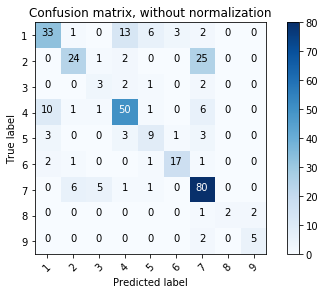

In [37]:
# Load the best iteration
best_model = load_model('models/best_weights.h5')

# Make the predictions
preds = best_model.predict_classes(x_test)
preds = [i + 1 for i in preds]

# Create the confusion matrix
cm = confusion_matrix(y_test_true, preds, labels=[1,2,3,4,5,6,7,8,9])

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[1,2,3,4,5,6,7,8,9], title='Confusion matrix, without normalization')
plt.show()

In [38]:
# Calculate accuracy
acc = np.sum(np.diag(cm)) / np.sum(cm)
print('Accuracy: %0.5f' % acc)
print(best_model.evaluate(x_test, y_test))

Accuracy: 0.66967
333/333 [==============================] - 1s 2ms/step
[1.3472904475243599, 0.6696696703856414]


In [ ]:
# Save the model in case we want to reference it later
best_model.save('models/iteration2.h5')

The model actually performs better with only a single hidden layer. Next, let's test dropout regularization.

### Tuning Dropout

In [39]:
from keras.layers import Dropout

# Load the best model
best_model = load_model('models/iteration1.h5')

# Test the impact of adding a dropout layer
# Use the pre-trained weights from the previous run
def dropout(rate=0.5):
    model = Sequential()
    model.add(Dropout(rate=rate, input_shape=(x_train.shape[1],)))
    model.add(Dense(1500, activation='relu'))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return (model)

# Setting the input params
rate = [0, 0.25, 0.5, 0.75] # Dropout rates
folds = 3 # Number of k-folds
seed = 1986 # Random seed for reproducibility

# Training the model
gs3 = KerasClassifierGridSearchCV(rate, folds, seed)
gs3.fit(dropout, x_train, y_train, epochs=50, batch_size=50, early_stopping_rounds=5, min_delta=0.001)

Training with: 0
Train on 1992 samples, validate on 996 samples
Epoch 1/50
 - 10s - loss: 1.9371 - acc: 0.2987 - val_loss: 1.8356 - val_acc: 0.2540
Epoch 2/50
 - 9s - loss: 1.7001 - acc: 0.3474 - val_loss: 1.7119 - val_acc: 0.2972
Epoch 3/50
 - 9s - loss: 1.5543 - acc: 0.4357 - val_loss: 1.5564 - val_acc: 0.4518
Epoch 4/50
 - 9s - loss: 1.4026 - acc: 0.5266 - val_loss: 1.4312 - val_acc: 0.4970
Epoch 5/50
 - 9s - loss: 1.2709 - acc: 0.5713 - val_loss: 1.3421 - val_acc: 0.5201
Epoch 6/50
 - 9s - loss: 1.1636 - acc: 0.6124 - val_loss: 1.2806 - val_acc: 0.5502
Epoch 7/50
 - 9s - loss: 1.0778 - acc: 0.6511 - val_loss: 1.2387 - val_acc: 0.5572
Epoch 8/50
 - 9s - loss: 1.0073 - acc: 0.6647 - val_loss: 1.2013 - val_acc: 0.5853
Epoch 9/50
 - 9s - loss: 0.9457 - acc: 0.6893 - val_loss: 1.1722 - val_acc: 0.5823
Epoch 10/50
 - 9s - loss: 0.8894 - acc: 0.7134 - val_loss: 1.1638 - val_acc: 0.5813
Epoch 11/50
 - 9s - loss: 0.8386 - acc: 0.7229 - val_loss: 1.1450 - val_acc: 0.5813
Epoch 12/50
 - 9s - 

Epoch 22/50
 - 9s - loss: 0.5351 - acc: 0.8092 - val_loss: 1.0896 - val_acc: 0.6004
Epoch 23/50
 - 9s - loss: 0.5203 - acc: 0.8208 - val_loss: 1.0962 - val_acc: 0.6034
Epoch 24/50
 - 9s - loss: 0.4948 - acc: 0.8238 - val_loss: 1.1108 - val_acc: 0.5934
Epoch 25/50
 - 9s - loss: 0.4866 - acc: 0.8258 - val_loss: 1.1077 - val_acc: 0.6104
Epoch 26/50
 - 9s - loss: 0.4697 - acc: 0.8338 - val_loss: 1.1263 - val_acc: 0.6034
Epoch 27/50
 - 9s - loss: 0.4580 - acc: 0.8313 - val_loss: 1.1541 - val_acc: 0.6074
Epoch 28/50
 - 9s - loss: 0.4452 - acc: 0.8363 - val_loss: 1.1251 - val_acc: 0.6054
Epoch 29/50
 - 9s - loss: 0.4350 - acc: 0.8409 - val_loss: 1.1400 - val_acc: 0.6135
Epoch 30/50
 - 9s - loss: 0.4295 - acc: 0.8414 - val_loss: 1.1517 - val_acc: 0.6124
Epoch 31/50
 - 9s - loss: 0.4131 - acc: 0.8484 - val_loss: 1.1384 - val_acc: 0.6004
Epoch 32/50
 - 9s - loss: 0.4190 - acc: 0.8399 - val_loss: 1.1672 - val_acc: 0.6024
Epoch 33/50
 - 9s - loss: 0.4038 - acc: 0.8494 - val_loss: 1.1548 - val_acc:

Epoch 13/50
 - 9s - loss: 0.8788 - acc: 0.7058 - val_loss: 1.0903 - val_acc: 0.6225
Epoch 14/50
 - 9s - loss: 0.8458 - acc: 0.7129 - val_loss: 1.0840 - val_acc: 0.6205
Epoch 15/50
 - 9s - loss: 0.7978 - acc: 0.7314 - val_loss: 1.0730 - val_acc: 0.6195
Epoch 16/50
 - 9s - loss: 0.7824 - acc: 0.7254 - val_loss: 1.0692 - val_acc: 0.6245
Epoch 17/50
 - 9s - loss: 0.7531 - acc: 0.7435 - val_loss: 1.0632 - val_acc: 0.6225
Epoch 18/50
 - 9s - loss: 0.7251 - acc: 0.7460 - val_loss: 1.0710 - val_acc: 0.6135
Epoch 19/50
 - 9s - loss: 0.7064 - acc: 0.7565 - val_loss: 1.0608 - val_acc: 0.6114
Epoch 20/50
 - 9s - loss: 0.6817 - acc: 0.7595 - val_loss: 1.0588 - val_acc: 0.6205
Epoch 21/50
 - 9s - loss: 0.6718 - acc: 0.7620 - val_loss: 1.0561 - val_acc: 0.6195
Epoch 00021: early stopping
996/996 [==============================] - 1s 823us/step
Train on 1992 samples, validate on 996 samples
Epoch 1/50
 - 11s - loss: 1.9612 - acc: 0.2741 - val_loss: 1.7751 - val_acc: 0.3193
Epoch 2/50
 - 9s - loss: 1.7

Epoch 15/50
 - 9s - loss: 0.9954 - acc: 0.6381 - val_loss: 1.0666 - val_acc: 0.6285
Epoch 16/50
 - 9s - loss: 0.9832 - acc: 0.6672 - val_loss: 1.0540 - val_acc: 0.6325
Epoch 17/50
 - 9s - loss: 0.9552 - acc: 0.6621 - val_loss: 1.0453 - val_acc: 0.6305
Epoch 18/50
 - 9s - loss: 0.9148 - acc: 0.6842 - val_loss: 1.0264 - val_acc: 0.6285
Epoch 19/50
 - 9s - loss: 0.8842 - acc: 0.6842 - val_loss: 1.0426 - val_acc: 0.6135
Epoch 20/50
 - 9s - loss: 0.8522 - acc: 0.7028 - val_loss: 1.0142 - val_acc: 0.6446
Epoch 21/50
 - 9s - loss: 0.8458 - acc: 0.6953 - val_loss: 1.0063 - val_acc: 0.6396
Epoch 22/50
 - 9s - loss: 0.8397 - acc: 0.6988 - val_loss: 1.0056 - val_acc: 0.6315
Epoch 23/50
 - 9s - loss: 0.8039 - acc: 0.7274 - val_loss: 1.0017 - val_acc: 0.6456
Epoch 24/50
 - 9s - loss: 0.7889 - acc: 0.7154 - val_loss: 0.9934 - val_acc: 0.6406
Epoch 25/50
 - 9s - loss: 0.7719 - acc: 0.7259 - val_loss: 0.9874 - val_acc: 0.6365
Epoch 26/50
 - 9s - loss: 0.7626 - acc: 0.7415 - val_loss: 0.9936 - val_acc:

In [40]:
print(gs3.get_avg_results())

{0: 0.61613119143239625, 0.25: 0.62014725568942441, 0.5: 0.61813922356091033, 0.75: 0.61144578313253006}


In [41]:
print(gs3.get_results()[0.25])

[0.60742971887550201, 0.61847389558232935, 0.63453815261044177]


In [42]:
# Get the best model 
best_model = gs3.get_models()[0.25][2]

# Save the model
best_model.save('models/iteration3.h5')

In [43]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, verbose=True)

# Checkpoint - used to get the best weights during the model training process
checkpoint = ModelCheckpoint(filepath='models/best_weights.h5', monitor='val_acc', save_best_only=True)

# Fit the pre-trained best model on the entire dataset
best_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping, checkpoint], verbose=2)

Train on 2988 samples, validate on 333 samples
Epoch 1/50
 - 22s - loss: 0.7480 - acc: 0.7296 - val_loss: 1.0098 - val_acc: 0.6216
Epoch 2/50
 - 22s - loss: 0.6938 - acc: 0.7426 - val_loss: 1.0223 - val_acc: 0.6216
Epoch 3/50
 - 22s - loss: 0.6600 - acc: 0.7550 - val_loss: 0.9999 - val_acc: 0.6486
Epoch 4/50
 - 22s - loss: 0.6133 - acc: 0.7774 - val_loss: 1.0137 - val_acc: 0.6517
Epoch 5/50
 - 20s - loss: 0.5865 - acc: 0.7781 - val_loss: 1.0019 - val_acc: 0.6456
Epoch 6/50
 - 22s - loss: 0.5568 - acc: 0.7855 - val_loss: 0.9917 - val_acc: 0.6637
Epoch 7/50
 - 22s - loss: 0.5477 - acc: 0.7915 - val_loss: 1.0212 - val_acc: 0.6757
Epoch 8/50
 - 20s - loss: 0.5181 - acc: 0.7959 - val_loss: 0.9825 - val_acc: 0.6727
Epoch 9/50
 - 20s - loss: 0.5090 - acc: 0.8062 - val_loss: 1.0354 - val_acc: 0.6727
Epoch 10/50
 - 20s - loss: 0.5007 - acc: 0.8056 - val_loss: 1.0166 - val_acc: 0.6667
Epoch 11/50
 - 20s - loss: 0.4773 - acc: 0.8139 - val_loss: 0.9909 - val_acc: 0.6577
Epoch 12/50
 - 20s - loss: 

Confusion matrix, without normalization


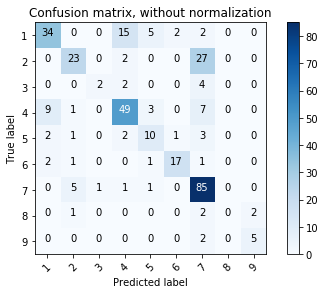

In [44]:
# Load the best iteration
best_model = load_model('models/best_weights.h5')

# Make the predictions
preds = best_model.predict_classes(x_test)
preds = [i + 1 for i in preds]

# Create the confusion matrix
cm = confusion_matrix(y_test_true, preds, labels=[1,2,3,4,5,6,7,8,9])

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[1,2,3,4,5,6,7,8,9], title='Confusion matrix, without normalization')
plt.show()

In [45]:
# Calculate accuracy
acc = np.sum(np.diag(cm)) / np.sum(cm)
print('Accuracy: %0.5f' % acc)
print(best_model.evaluate(x_test, y_test))

Accuracy: 0.67568
333/333 [==============================] - 1s 2ms/step
[1.0212397825968516, 0.67567567621265445]


In [46]:
# Save the model in case we want to reference it later
best_model.save('models/iteration3.h5')